# Aggregate the OGGM raw files to regional or global summed up csv files


*Note that the paths of this notebook only work if you are running the notebook from the OGGM cluster*


In [1]:
import xarray as xr
import pandas as pd
import progressbar
import numpy as np
from oggm.utils import mkdir
import matplotlib.pyplot as plt
import json
import os

In [2]:
%pwd

'/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/notebooks'

In [3]:
dirpath = '/home/www/oggm/oggm-standard-projections/oggm_v16/2023.3/'
outputpath = '/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1'
# we only aggregate here `w5e5_gcm_merged`, but you could repeat this here with `gcm_from_2000` as it is also available in the raw per-glacier datafiles
historical_future_option = 'w5e5_gcm_merged'

# this is the only preprocessed version (i.e., we match the geodetic observations on any individual glacier)
exp = 'match_geod_pergla'
oggm_version = 'oggm_v1.6.1_2023.3'

rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')
rgi_meta = rgi_meta.loc[rgi_meta.Connect != 2]

## A. Common running glacier aggregations for all projections, until 2100 and until 2300, i.e. `common_running_2100_2300`
- the same for only until 2100 is done in Section B further below

### A. 1: GCMs - missing glaciers overview  

In [4]:
allfiles = []
for root, dirs, files in os.walk(dirpath):
    for file in files:
        if (file.endswith(".nc")) and ('run_hydro' in file) and (historical_future_option in file) and ('_0_1000' in file) and ('basin' not in file):
             allfiles.append(os.path.join(root, file))

df_meta = pd.DataFrame()
invalid_per_reg = {}  
meta_per_reg = {}

In [5]:
run = True
if run:
    # this takes very long !!!
    invalid_per_reg = {}  
    meta_per_reg = {}
    for f in allfiles: #progressbar.progressbar(allfiles):
        ename = f.replace(dirpath, '')
        ss = ename.split('/')
        cmip = ss[0]
        endyr = ss[1]
        rgi_reg = ss[2]
        gcm_original = ss[3].split('_')[5] #ss[2]
        gcm = gcm_original.upper()
        if 'ISIMIP3b' in cmip:
            ssp = ss[3].split('_')[7]
            bc = 'ISIMIP3b:1979-2014'
        else:
            ssp = ss[3].split('_')[6]
            bc = '2000-2019'

        end0,end1 = ss[3].split('_')[-2:]
        end = end0+'_'+end1
        ff = f[:-len(end)]+'*'

        #if ssp not in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
        #    continue

        # exp is the same everywhere, so we don't need as an id... 
        run_id = f'{cmip}:{endyr}:{gcm}:{ssp}:{rgi_reg}'
        df_meta.loc[run_id, 'cmip'] = cmip
        df_meta.loc[run_id, 'gcm_original'] = gcm_original # some have lower and upper cases in the raw output files
        df_meta.loc[run_id, 'gcm'] = gcm  # for the aggregated files, all GCMs are in upper cases
        df_meta.loc[run_id, 'scenario'] = ssp
        df_meta.loc[run_id, 'rgi_reg'] = rgi_reg
        df_meta.loc[run_id, 'end_year'] = 0
        df_meta.loc[run_id, 'bias_correction'] = bc

        df_meta.loc[run_id, 'perc_area_missing'] = 0

        df_meta.loc[run_id, 'fpath'] = ff

        if rgi_reg not in invalid_per_reg:
            invalid_per_reg[rgi_reg] = set()

        if rgi_reg not in meta_per_reg:
            meta_per_reg[rgi_reg] = rgi_meta.loc[rgi_meta['O1Region'] == rgi_reg[-2:]]

        with xr.open_mfdataset(ff) as ds:
            ds_t = ds.isel(time=-1).volume.load()
        df_meta.loc[run_id, 'end_year'] = str(int(ds_t.time))
        missing_ids = ds_t.rgi_id[ds_t.isnull()].data
        perc = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum() / meta_per_reg[rgi_reg]['Area'].sum() 
        df_meta.loc[run_id, 'perc_area_missing'] = perc
        invalid_per_reg[rgi_reg] = invalid_per_reg[rgi_reg].union(missing_ids)
        if f == allfiles[1000] or f==allfiles[2000]:
            print(f)
    df_meta['exp'] = exp
    df_meta['historical_future_option'] = historical_future_option
    df_meta['oggm_version'] = oggm_version
    df_meta.to_csv(f'{outputpath}/common_running_2100_2300/metadata.csv')
else:
    df_meta = pd.read_csv(f'{outputpath}/common_running_2100_2300/metadata.csv')

/home/www/oggm/oggm-standard-projections/oggm_v16/2023.3/CMIP6/2100/RGI12/run_hydro_w5e5_gcm_merged_CAMS-CSM1-0_ssp585_bc_2000_2019_Batch_0_1000.nc
/home/www/oggm/oggm-standard-projections/oggm_v16/2023.3/CMIP5/2100/RGI06/run_hydro_w5e5_gcm_merged_MPI-ESM-LR_rcp26_bc_2000_2019_Batch_0_1000.nc


In [13]:
df_meta.cmip.unique()

array(['ISIMIP3b_CMIP6', 'CMIP6', 'CMIP5'], dtype=object)

In [7]:
dds = df_meta.sort_values('perc_area_missing', ascending=False)
dds[dds['perc_area_missing'] > 0.05].rgi_reg.unique()

array(['RGI12', 'RGI06', 'RGI08'], dtype=object)

In [8]:
dds

,cmip,gcm_original,gcm,scenario,rgi_reg,end_year,bias_correction,perc_area_missing,fpath,exp,historical_future_option,oggm_version
CMIP5:2300:MPI-ESM-LR:rcp26:RGI12,CMIP5,MPI-ESM-LR,MPI-ESM-LR,rcp26,RGI12,2300,2000-2019,0.130445,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2300:MPI-ESM-LR:rcp85:RGI12,CMIP5,MPI-ESM-LR,MPI-ESM-LR,rcp85,RGI12,2300,2000-2019,0.129181,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2300:MPI-ESM-LR:rcp45:RGI12,CMIP5,MPI-ESM-LR,MPI-ESM-LR,rcp45,RGI12,2300,2000-2019,0.123297,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:CANESM2:rcp26:RGI12,CMIP5,CanESM2,CANESM2,rcp26,RGI12,2100,2000-2019,0.121243,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:NORESM2-MM:ssp126:RGI12,CMIP6,NorESM2-MM,NORESM2-MM,ssp126,RGI12,2100,2000-2019,0.120892,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
...,...,...,...,...,...,...,...,...,...,...,...,...
CMIP6:2100:CESM2-WACCM:ssp370:RGI07,CMIP6,CESM2-WACCM,CESM2-WACCM,ssp370,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:CAMS-CSM1-0:ssp370:RGI07,CMIP6,CAMS-CSM1-0,CAMS-CSM1-0,ssp370,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:FGOALS-F3-L:ssp585:RGI07,CMIP6,FGOALS-f3-L,FGOALS-F3-L,ssp585,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:CAMS-CSM1-0:ssp245:RGI07,CMIP6,CAMS-CSM1-0,CAMS-CSM1-0,ssp245,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3


In [9]:
for k, v in invalid_per_reg.items():
    invalid_per_reg[k] = list(v)
with open(f'{outputpath}/common_running_2100_2300/rgi_ids_missing.json', 'w') as f:
    json.dump(invalid_per_reg, f)

In [10]:
# these are now the common running glaciers over all scenarios and GCMs and all cmip variants going until 2100 or until 2300
odf = pd.DataFrame()
for rgi_reg, missing_ids in invalid_per_reg.items():
    odf.loc[rgi_reg, 'n_glaciers'] = len(meta_per_reg[rgi_reg])
    odf.loc[rgi_reg, 'n_missing_glaciers'] = len(missing_ids)
    odf.loc[rgi_reg, 'rgi_area_km2'] = meta_per_reg[rgi_reg]['Area'].sum() 
    odf.loc[rgi_reg, 'missing_area_km2'] = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum()
    odf.loc[rgi_reg, 'missing_area_perc'] = odf.loc[rgi_reg, 'missing_area_km2'] / odf.loc[rgi_reg, 'rgi_area_km2']
odf[['n_glaciers', 'n_missing_glaciers']] = odf[['n_glaciers', 'n_missing_glaciers']].astype(int)
odf = odf.sort_values(by='missing_area_perc', ascending=False)
odf

,n_glaciers,n_missing_glaciers,rgi_area_km2,missing_area_km2,missing_area_perc
RGI12,1888,409,1306.992,160.691,0.122947
RGI06,568,420,11059.700,963.393,0.087108
RGI08,3417,1152,2949.103,237.021,0.080371
RGI10,5151,243,2410.051,94.172,0.039075
RGI05,19306,1662,89717.066,1467.785,0.016360
RGI07,1615,48,33958.934,238.343,0.007019
RGI13,54429,862,49303.415,311.203,0.006312
RGI14,27988,501,33568.298,102.782,0.003062
RGI19,2752,633,132867.219,377.671,0.002842
RGI04,7415,313,40888.228,100.893,0.002468


In [15]:
odf.to_csv(f'{outputpath}/common_running_2100_2300/missing_region_overview.csv')
odf.to_html(f'{outputpath}/common_running_2100_2300/missing_region_overview.html')

### A. 2: GCMs - aggregation

In [16]:
base_dir =f'{outputpath}/common_running_2100_2300'
df_meta = pd.read_csv(f'{base_dir}/metadata.csv', index_col = 0)
import json
with open(f'{base_dir}/rgi_ids_missing.json', 'r') as f:
    invalid_per_reg = json.load(f)

In [17]:
for cmip in df_meta.cmip.unique():
    #print(cmip, flush=True)
    if cmip == 'CMIP6' or cmip == 'CMIP5':
        end_years = [2100, 2300]
    else:
        end_years = [2100]
    for end_year in end_years:
        for rgi_reg in sorted(df_meta.rgi_reg.unique()): #progressbar.progressbar(
            for scenario in sorted(df_meta.loc[(df_meta.cmip==cmip) & (df_meta.end_year == end_year)].scenario.unique()):
                df_meta_s = df_meta.loc[(df_meta.end_year == end_year) & (df_meta.cmip == cmip) & (df_meta.rgi_reg == rgi_reg) & (df_meta.scenario == scenario)]
                odf_v = pd.DataFrame()
                odf_a = pd.DataFrame()
                ods = []
                gcms = []
                for i, s in df_meta_s.iterrows():
                    with xr.open_mfdataset(s.fpath) as ds:
                        ds = ds[['volume', 'area']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        odf_v[s.gcm] = ds.volume.sum(dim='rgi_id').to_series()
                        odf_a[s.gcm] = ds.area.sum(dim='rgi_id').to_series()
                        ods.append(ds)
                        gcms.append(s.gcm)
                ods = xr.concat(ods, 'gcm')

                # we don't like to have these kind of summary statistics as the user does not know
                # whether the different projections are gaussian distributed ... 
                #ods.mean(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_avg_{scenario}.nc')
                #ods.std(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_std_{scenario}.nc')
                odir =  f'{base_dir}/volume/{cmip}/{end_year}/{rgi_reg}/'
                mkdir(odir)
                odf_v.to_csv(odir + f'{scenario}.csv')
                odir = f'{base_dir}/area/{cmip}/{end_year}/{rgi_reg}/'
                mkdir(odir)
                odf_a.to_csv(odir + f'{scenario}.csv')

In [18]:
# globally: sum over all RGI regions
for var in ['volume', 'area']:
    for cmip in df_meta.cmip.unique():
        if cmip == 'CMIP6' or cmip == 'CMIP5':
            end_years = [2100, 2300]
        else:
            end_years = [2100]
        for end_year in end_years:
            odir = f'{base_dir}/{var}/{cmip}/{end_year}/global/'
            mkdir(odir)
            for scenario in sorted(df_meta.loc[(df_meta.cmip==cmip) & (df_meta.end_year == end_year)].scenario.unique()):
                odf = 0
                for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                    idir = f'{base_dir}/{var}/{cmip}/{end_year}/{rgi_reg}/'
                    df = pd.read_csv(idir + f'/{scenario}.csv', index_col=0)
                    odf += df
                odf.to_csv(odir + f'/{scenario}.csv')
                

## B. Common running glacier aggregations for all projections until 2100, i.e. `common_running_2100`

### B. 1: GCMs - missing glaciers overview  

In [19]:
allfiles = []
for root, dirs, files in os.walk(dirpath):
    if not '/2300/' in root:
        for file in files:
            if (file.endswith(".nc")) and ('run_hydro' in file) and (historical_future_option in file) and ('_0_1000' in file) and ('basin' not in file):
                 allfiles.append(os.path.join(root, file))

df_meta = pd.DataFrame()
invalid_per_reg = {}  
meta_per_reg = {}

In [20]:
print(len(allfiles))

2432


In [21]:
# this takes very long !!!
invalid_per_reg = {}  
meta_per_reg = {}
for f in allfiles: #progressbar.progressbar(allfiles):
    ename = f.replace(dirpath, '')
    ss = ename.split('/')
    cmip = ss[0]
    endyr = ss[1]
    rgi_reg = ss[2]
    gcm_original = ss[3].split('_')[5] 
    gcm = gcm_original.upper()
    if 'ISIMIP3b' in cmip:
        ssp = ss[3].split('_')[7]
        bc = 'ISIMIP3b:1979-2014'
    else:
        ssp = ss[3].split('_')[6]
        bc = '2000-2019'

    end0,end1 = ss[3].split('_')[-2:]
    end = end0+'_'+end1
    ff = f[:-len(end)]+'*'

    # exp is the same everywhere, so we don't need it as an id... 
    run_id = f'{cmip}:{endyr}:{gcm}:{ssp}:{rgi_reg}'
    df_meta.loc[run_id, 'cmip'] = cmip
    df_meta.loc[run_id, 'gcm_original'] = gcm_original # some have lower and upper cases in the raw output files
    df_meta.loc[run_id, 'gcm'] = gcm  # for the aggregated files, all GCMs are in upper cases
    df_meta.loc[run_id, 'scenario'] = ssp
    df_meta.loc[run_id, 'rgi_reg'] = rgi_reg
    df_meta.loc[run_id, 'end_year'] = 0  # will be updated later
    df_meta.loc[run_id, 'bias_correction'] = bc

    df_meta.loc[run_id, 'perc_area_missing'] = 0
    
    df_meta.loc[run_id, 'fpath'] = ff
    
    if rgi_reg not in invalid_per_reg:
        invalid_per_reg[rgi_reg] = set()
    
    if rgi_reg not in meta_per_reg:
        meta_per_reg[rgi_reg] = rgi_meta.loc[rgi_meta['O1Region'] == rgi_reg[-2:]]
    
    with xr.open_mfdataset(ff) as ds:
        ds_t = ds.isel(time=-1).volume.load()
    df_meta.loc[run_id, 'end_year'] = str(int(ds_t.time))
    missing_ids = ds_t.rgi_id[ds_t.isnull()].data
    perc = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum() / meta_per_reg[rgi_reg]['Area'].sum() 
    df_meta.loc[run_id, 'perc_area_missing'] = perc
    invalid_per_reg[rgi_reg] = invalid_per_reg[rgi_reg].union(missing_ids)
    if f == allfiles[100]:
        print(f)
df_meta['exp'] = exp
df_meta['historical_future_option'] = historical_future_option
df_meta['oggm_version'] = oggm_version
df_meta.to_csv(f'{outputpath}/common_running_2100/metadata.csv')

/home/www/oggm/oggm-standard-projections/oggm_v16/2023.3/ISIMIP3b_CMIP6/2100/RGI12/run_hydro_w5e5_gcm_merged_gfdl-esm4_r1i1p1f1_ssp370_Batch_0_1000.nc


In [22]:
dds = df_meta.sort_values('perc_area_missing', ascending=False)
dds[dds['perc_area_missing'] > 0.05].rgi_reg.unique()

array(['RGI12'], dtype=object)

In [23]:
dds

,cmip,gcm_original,gcm,scenario,rgi_reg,end_year,bias_correction,perc_area_missing,fpath,exp,historical_future_option,oggm_version
CMIP5:2100:CANESM2:rcp26:RGI12,CMIP5,CanESM2,CANESM2,rcp26,RGI12,2100,2000-2019,0.121243,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:NORESM2-MM:ssp126:RGI12,CMIP6,NorESM2-MM,NORESM2-MM,ssp126,RGI12,2100,2000-2019,0.120892,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:IPSL-CM5A-LR:rcp26:RGI12,CMIP5,IPSL-CM5A-LR,IPSL-CM5A-LR,rcp26,RGI12,2100,2000-2019,0.119703,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:MPI-ESM-LR:rcp26:RGI12,CMIP5,MPI-ESM-LR,MPI-ESM-LR,rcp26,RGI12,2100,2000-2019,0.119397,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:CANESM2:rcp45:RGI12,CMIP5,CanESM2,CANESM2,rcp45,RGI12,2100,2000-2019,0.119350,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
...,...,...,...,...,...,...,...,...,...,...,...,...
CMIP5:2100:CNRM-CM5:rcp26:RGI07,CMIP5,CNRM-CM5,CNRM-CM5,rcp26,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:MRI-ESM2-0:ssp585:RGI07,CMIP6,MRI-ESM2-0,MRI-ESM2-0,ssp585,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:IPSL-CM6A-LR:ssp534-over:RGI07,CMIP6,IPSL-CM6A-LR,IPSL-CM6A-LR,ssp534-over,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP6:2100:GFDL-ESM4:ssp126:RGI07,CMIP6,GFDL-ESM4,GFDL-ESM4,ssp126,RGI07,2100,2000-2019,0.000000,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3


In [24]:
for k, v in invalid_per_reg.items():
    invalid_per_reg[k] = list(v)
with open(f'{outputpath}/common_running_2100/rgi_ids_missing.json', 'w') as f:
    json.dump(invalid_per_reg, f)

# these are now the common running glaciers over all scenarios and GCMs and all cmip variants going until 2100 or until 2300
odf = pd.DataFrame()
for rgi_reg, missing_ids in invalid_per_reg.items():
    odf.loc[rgi_reg, 'n_glaciers'] = len(meta_per_reg[rgi_reg])
    odf.loc[rgi_reg, 'n_missing_glaciers'] = len(missing_ids)
    odf.loc[rgi_reg, 'rgi_area_km2'] = meta_per_reg[rgi_reg]['Area'].sum() 
    odf.loc[rgi_reg, 'missing_area_km2'] = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum()
    odf.loc[rgi_reg, 'missing_area_perc'] = odf.loc[rgi_reg, 'missing_area_km2'] / odf.loc[rgi_reg, 'rgi_area_km2']
odf[['n_glaciers', 'n_missing_glaciers']] = odf[['n_glaciers', 'n_missing_glaciers']].astype(int)
odf = odf.sort_values(by='missing_area_perc', ascending=False)
odf

,n_glaciers,n_missing_glaciers,rgi_area_km2,missing_area_km2,missing_area_perc
RGI12,1888,409,1306.992,160.691,0.122947
RGI10,5151,168,2410.051,89.351,0.037074
RGI19,2752,598,132867.219,301.246,0.002267
RGI13,54429,345,49303.415,92.609,0.001878
RGI17,15908,94,29429.080,49.960,0.001698
RGI03,4556,77,105110.642,176.943,0.001683
RGI05,19306,344,89717.066,88.617,0.000988
RGI15,13119,41,14734.204,11.674,0.000792
RGI14,27988,136,33568.298,23.149,0.000690
RGI11,3927,31,2092.146,1.074,0.000513


In [25]:
odf.to_csv(f'{outputpath}/common_running_2100/missing_region_overview.csv')
odf.to_html(f'{outputpath}/common_running_2100/missing_region_overview.html')

### B. 2: GCMs - aggregation

In [26]:
base_dir =f'{outputpath}/common_running_2100'
df_meta = pd.read_csv(f'{base_dir}/metadata.csv', index_col = 0)
with open(f'{base_dir}/rgi_ids_missing.json', 'r') as f:
    invalid_per_reg = json.load(f)

In [27]:
for cmip in df_meta.cmip.unique():
    print(cmip, flush=True)
    if cmip == 'CMIP6':
        end_years = [2100]
    else:
        end_years = [2100]
    for end_year in end_years:
        for rgi_reg in sorted(df_meta.rgi_reg.unique()): #progressbar.progressbar(
            for scenario in sorted(df_meta.loc[(df_meta.cmip==cmip) & (df_meta.end_year == end_year)].scenario.unique()):
                df_meta_s = df_meta.loc[(df_meta.end_year == end_year) & (df_meta.cmip == cmip) & (df_meta.rgi_reg == rgi_reg) & (df_meta.scenario == scenario)]
                odf_v = pd.DataFrame()
                odf_a = pd.DataFrame()
                ods = []
                gcms = []
                for i, s in df_meta_s.iterrows():
                    with xr.open_mfdataset(s.fpath) as ds:
                        ds = ds[['volume', 'area']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        #ds = ds[['volume', 'area', 'length']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        odf_v[s.gcm] = ds.volume.sum(dim='rgi_id').to_series()
                        odf_a[s.gcm] = ds.area.sum(dim='rgi_id').to_series()
                        ods.append(ds)
                        gcms.append(s.gcm)
                ods = xr.concat(ods, 'gcm')

                # I don't like to have these kind of summary statistics as the user does not know whether the different projections are gaussian distributed .. 
                #ods.mean(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_avg_{scenario}.nc')
                #ods.std(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_std_{scenario}.nc')
                odir =  f'{base_dir}/volume/{cmip}/{end_year}/{rgi_reg}/'
                mkdir(odir)
                odf_v.to_csv(odir + f'{scenario}.csv')
                odir = f'{base_dir}/area/{cmip}/{end_year}/{rgi_reg}/'
                mkdir(odir)
                odf_a.to_csv(odir + f'{scenario}.csv')

ISIMIP3b_CMIP6
CMIP6
CMIP5


In [28]:
# globally: sum over all RGI regions
for var in ['volume', 'area']:
    for cmip in df_meta.cmip.unique():
        odir = f'{base_dir}/{var}/{cmip}/{end_year}/global/'
        mkdir(odir)
        for scenario in sorted(df_meta.loc[(df_meta.cmip==cmip) & (df_meta.end_year == end_year)].scenario.unique()):
            odf = 0
            for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                idir = f'{base_dir}/{var}/{cmip}/{end_year}/{rgi_reg}/'
                df = pd.read_csv(idir + f'/{scenario}.csv', index_col=0)
                odf += df
            odf.to_csv(odir + f'/{scenario}.csv')

# Visualisation of missing common running glaciers

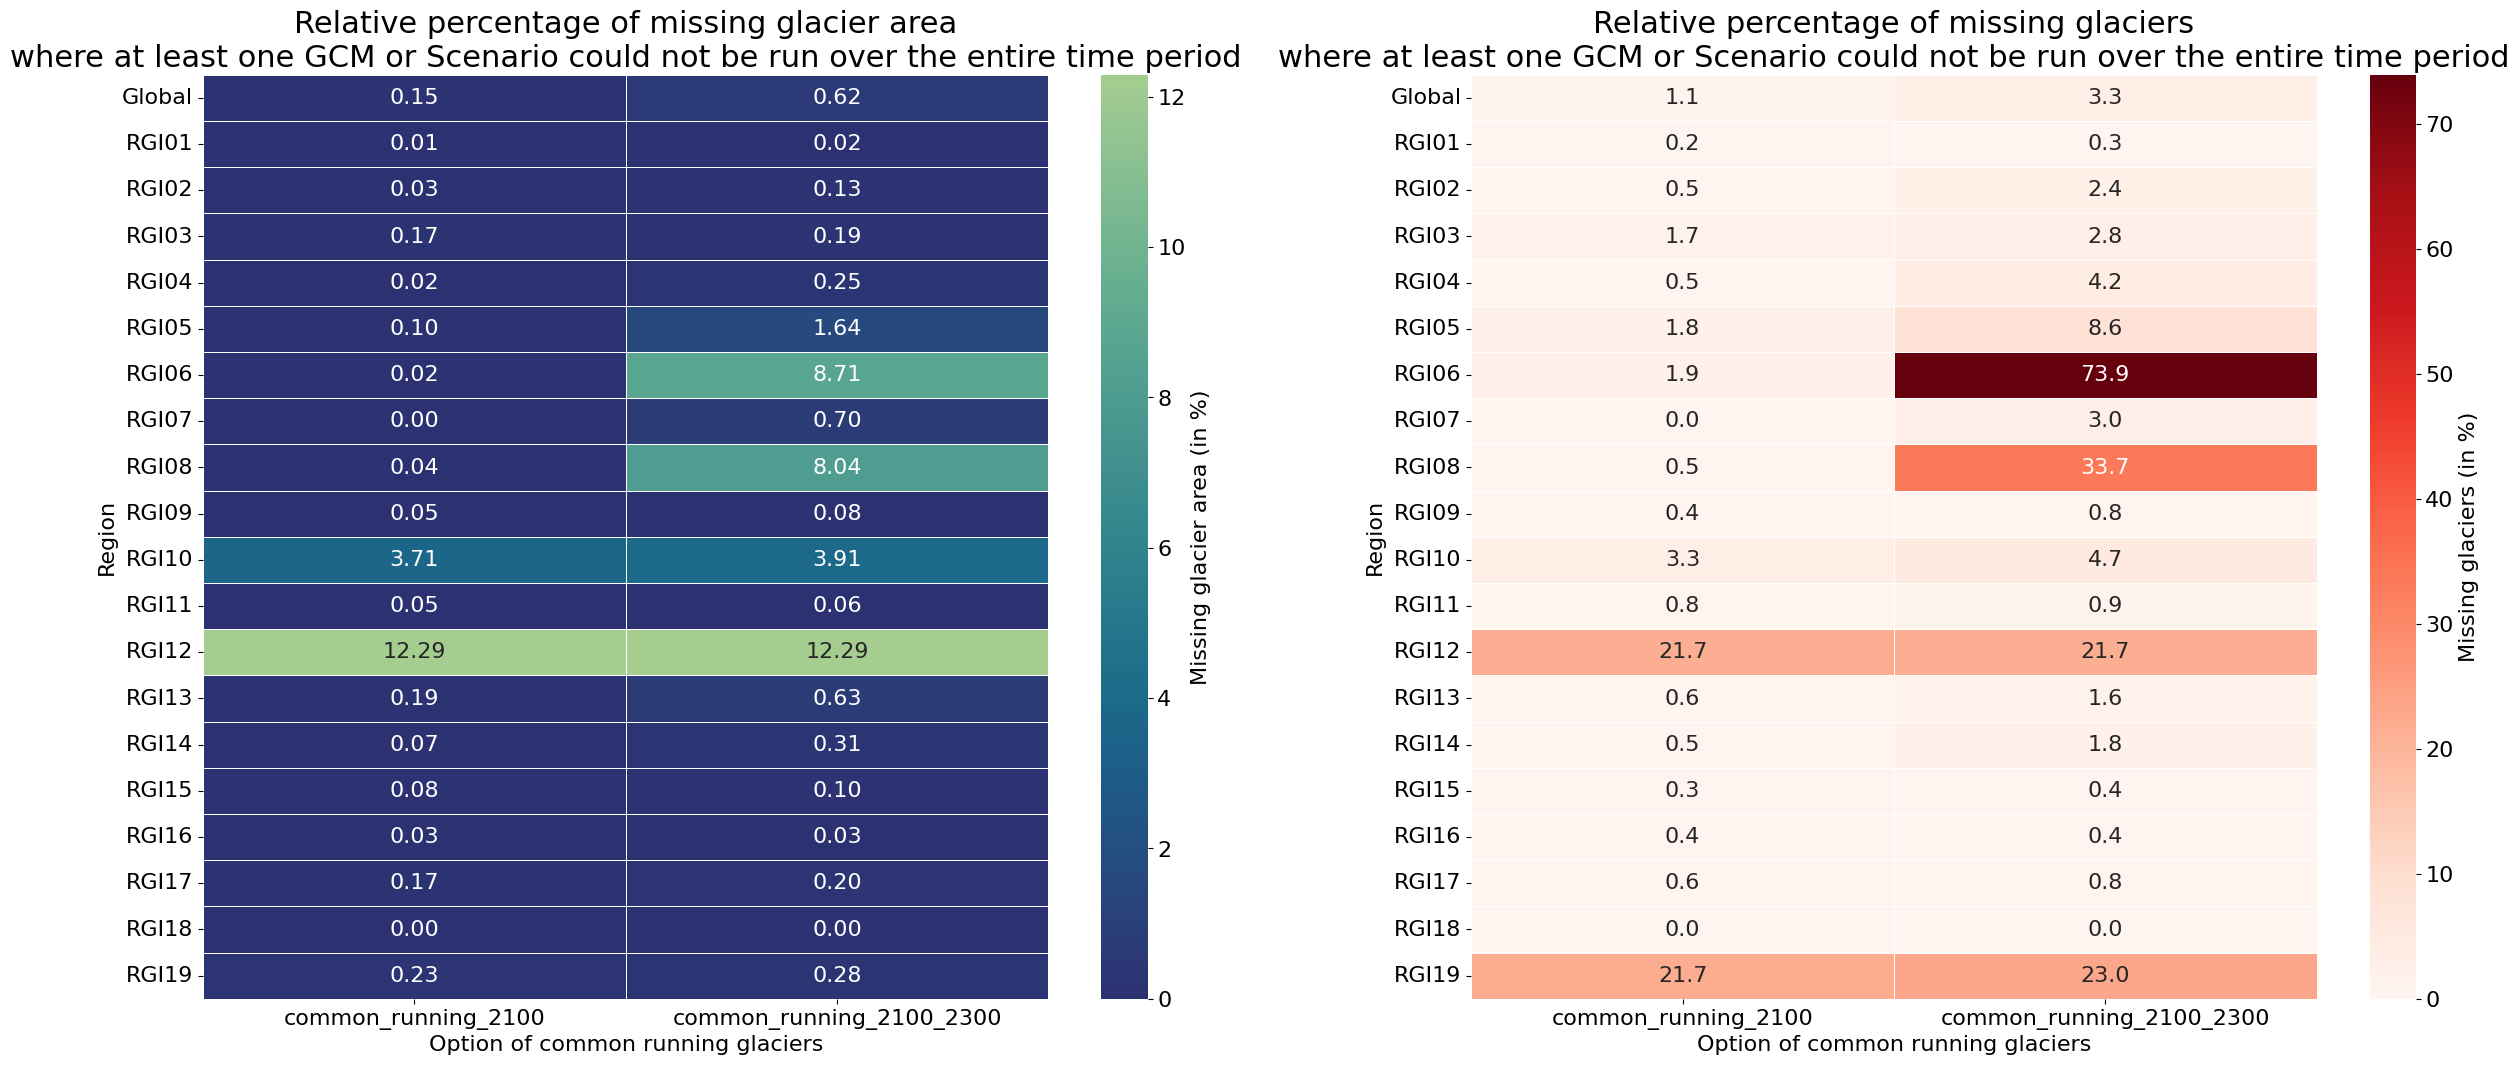

In [29]:
odf_2100= pd.read_csv(f'{outputpath}/common_running_2100/missing_region_overview.csv', index_col=0)
odf_2100.loc['Global'] = odf_2100.sum(axis=0)
# need to recompute the percentage
odf_2100['missing_area_perc'] = 100*odf_2100['missing_area_km2'] / odf_2100['rgi_area_km2']
odf_2100['missing_glaciers_perc'] = 100*odf_2100['n_missing_glaciers'] / odf_2100['n_glaciers']
odf_2100 = odf_2100.sort_index()

odf_2300= pd.read_csv(f'{outputpath}/common_running_2100_2300/missing_region_overview.csv', index_col=0)
odf_2300.loc['Global'] = odf_2300.sum(axis=0)
# need to recompute the percentage
odf_2300['missing_area_perc'] = 100*odf_2300['missing_area_km2'] / odf_2300['rgi_area_km2']
odf_2300['missing_glaciers_perc'] = 100*odf_2300['n_missing_glaciers'] / odf_2300['n_glaciers']
odf_2300 = odf_2300.sort_index()

import seaborn as sns

odf_area = odf_2100[['missing_area_perc']]
odf_area.index.name = 'Region'
odf_area.columns.name = 'Option of common running glaciers'
odf_area = odf_area.rename(columns={'missing_area_perc':'common_running_2100'})
odf_area['common_running_2100_2300'] = odf_2300['missing_area_perc']

odf_glac = odf_2100[['missing_glaciers_perc']]
odf_glac.index.name = 'Region'
odf_glac.columns.name = 'Option of common running glaciers'
odf_glac = odf_glac.rename(columns={'missing_glaciers_perc':'common_running_2100'})
odf_glac['common_running_2100_2300'] = odf_2300['missing_glaciers_perc']


plt.rc('font', size=16)
fig, axs = plt.subplots(1,2,figsize=(30,12))
ax = axs[0]
sns.heatmap(odf_area.astype(float), 
            ax=ax,
            annot=True, fmt=".2f",cmap="crest_r",linewidth=.5,
            cbar_kws={'label':'Missing glacier area (in %)'})
ax.set_title(f'Relative percentage of missing glacier area\nwhere at least one GCM or Scenario could not be run over the entire time period', fontsize=22)


ax = axs[1]
sns.heatmap(odf_glac.astype(float), annot=True, fmt=".1f",cmap="Reds",linewidth=.5, ax=ax,
            cbar_kws={'label':'Missing glaciers (in %)'})
ax.set_title(f'Relative percentage of missing glaciers\nwhere at least one GCM or Scenario could not be run over the entire time period', fontsize=22);
plt.savefig('missing_glacier_area_stats.png')


## Appendix
### C: common running with Rounce et al. (2023)

In [6]:
base_dir =f'/home/www/oggm/oggm-standard-projections/analysis_notebooks/1.6.1/common_running_rounce_et_al_2023'
df_meta = pd.read_csv(f'{outputpath}/common_running_2100/metadata.csv', index_col = 0)
import json
# this file has been created here: /home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/notebooks/analyse_csv_files_1.6.1.ipynb
with open(f'/home/www/oggm/oggm-standard-projections/analysis_notebooks/1.6.1/common_running_rounce_et_al_2023/rgi_ids_missing_rounce_et_al_or_oggm.json', 'r') as f:
    invalid_per_reg = json.load(f)

In [8]:
for cmip in ['CMIP6']:
    print(cmip, flush=True)
    if cmip == 'CMIP6':
        end_years = [2100]
    else:
        end_years = [2100]
    for end_year in end_years:
        for rgi_reg in sorted(df_meta.rgi_reg.unique()): #progressbar.progressbar(
            for scenario in ['ssp126', 'ssp245','ssp370', 'ssp585']:
                df_meta_s = df_meta.loc[(df_meta.end_year == end_year) & (df_meta.cmip == cmip) & (df_meta.rgi_reg == rgi_reg) & (df_meta.scenario == scenario)]
                odf_v = pd.DataFrame()
                odf_a = pd.DataFrame()
                ods = []
                gcms = []
                for i, s in df_meta_s.iterrows():
                    with xr.open_mfdataset(s.fpath) as ds:
                        ds = ds[['volume']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        #ds = ds[['volume', 'area', 'length']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        odf_v[s.gcm] = ds.volume.sum(dim='rgi_id').to_series()
                        ods.append(ds)
                        gcms.append(s.gcm)
                ods = xr.concat(ods, 'gcm')

                # I don't like to have these kind of summary statistics as the user does not know whether the different projections are gaussian distributed .. 
                #ods.mean(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_avg_{scenario}.nc')
                #ods.std(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_std_{scenario}.nc')
                odir =  f'{base_dir}/volume/{cmip}/{end_year}/{rgi_reg}/'
                mkdir(odir)
                odf_v.to_csv(odir + f'{scenario}.csv')


CMIP6


In [9]:
# globally: sum over all RGI regions
for var in ['volume']:
    for cmip in ['CMIP6']:
        if cmip == 'CMIP6':
            end_years = [2100]
        else:
            end_years = [2100]
        for end_year in end_years:
            odir = f'{base_dir}/{var}/{cmip}/{end_year}/global/'
            mkdir(odir)
            for scenario in ['ssp126', 'ssp245','ssp370', 'ssp585']:
                odf = 0
                for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                    idir = f'{base_dir}/{var}/{cmip}/{end_year}/{rgi_reg}/'
                    df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                    odf += df
                odf.to_csv(odir + f'{scenario}.csv')

In [10]:
df_meta

,cmip,gcm_original,gcm,scenario,rgi_reg,end_year,bias_correction,perc_area_missing,fpath,exp,historical_future_option,oggm_version
ISIMIP3b_CMIP6:2100:MRI-ESM2-0:ssp585:RGI11,ISIMIP3b_CMIP6,mri-esm2-0,MRI-ESM2-0,ssp585,RGI11,2100,ISIMIP3b:1979-2014,0.000495,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
ISIMIP3b_CMIP6:2100:UKESM1-0-LL:ssp585:RGI11,ISIMIP3b_CMIP6,ukesm1-0-ll,UKESM1-0-LL,ssp585,RGI11,2100,ISIMIP3b:1979-2014,0.000495,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
ISIMIP3b_CMIP6:2100:MRI-ESM2-0:ssp126:RGI11,ISIMIP3b_CMIP6,mri-esm2-0,MRI-ESM2-0,ssp126,RGI11,2100,ISIMIP3b:1979-2014,0.000495,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
ISIMIP3b_CMIP6:2100:UKESM1-0-LL:ssp370:RGI11,ISIMIP3b_CMIP6,ukesm1-0-ll,UKESM1-0-LL,ssp370,RGI11,2100,ISIMIP3b:1979-2014,0.000495,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
ISIMIP3b_CMIP6:2100:MRI-ESM2-0:ssp370:RGI11,ISIMIP3b_CMIP6,mri-esm2-0,MRI-ESM2-0,ssp370,RGI11,2100,ISIMIP3b:1979-2014,0.000495,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
...,...,...,...,...,...,...,...,...,...,...,...,...
CMIP5:2100:GFDL-CM3:rcp45:RGI04,CMIP5,GFDL-CM3,GFDL-CM3,rcp45,RGI04,2100,2000-2019,0.000053,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:CSIRO-MK3-6-0:rcp26:RGI04,CMIP5,CSIRO-Mk3-6-0,CSIRO-MK3-6-0,rcp26,RGI04,2100,2000-2019,0.000073,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:IPSL-CM5A-LR:rcp45:RGI04,CMIP5,IPSL-CM5A-LR,IPSL-CM5A-LR,rcp45,RGI04,2100,2000-2019,0.000063,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
CMIP5:2100:GFDL-CM3:rcp85:RGI04,CMIP5,GFDL-CM3,GFDL-CM3,rcp85,RGI04,2100,2000-2019,0.000053,/home/www/oggm/oggm-standard-projections/oggm_...,match_geod_pergla,w5e5_gcm_merged,oggm_v1.6.1_2023.3
